In [54]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import scienceplots
import latex

from sklearn.metrics import accuracy_score
import optuna
from optuna import Trial

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Set plotting parameters
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')

# Read data
df_og = load(config['PATH']['DATA_DIR'] + '/full_df_daily_cap95.joblib')

In [4]:
# Construct target as bad (0-6), okay (6-8), good (8-10)
df = df_og.copy()
# df = df.drop(columns = ['time'])
df['target'] = df['target'].apply(lambda x: 0 if x < 7 else 1)

# Impute outliers (larger than 1.5 IQR) with mean of column in all _sum columns
# for col in df.columns:
#     if col.endswith('_sum'):
#         df[col] = df[col].mask(df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)), df[col].mean())

In [5]:
X, y = df.drop(columns=['target'], axis = 1), df['target']

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_ts(X, y, split_ratios=[0.5, 0.2])

# Full train set for final model
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Get non-dummy columns
if len([var for var in df.columns if var.startswith('day')]) == 7:
    df = df.drop(columns=['day_of_week_0'])
dummy_cols = [var for var in df.columns if var.startswith('day')] + ['target', 'activity_idc', 'call_idc', 'sms_idc', 'id']
cols_no_dummy = [var for var in X_train.columns if var not in dummy_cols]

# Scale data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([('scaler', StandardScaler(), cols_no_dummy)], remainder='passthrough')
ct.set_output(transform='pandas')
X_train_scaled = ct.fit_transform(X_train)
X_val_scaled = ct.transform(X_val)


In [6]:
# Count number of days for each person and print
def count_days(df):
    for person in df['id'].unique():
        print(f"Person {person} has { len( df[df['id'] == person] )} days")

In [177]:
def shape_lstm(X, y, seq_length):
    import numpy as np

    X_lstm = []
    y_lstm = []
    
    # Iterate over persons:
    for person in X['remainder__id'].unique():
        # Get all days for this person
        X_person = X[X['remainder__id'] == person].drop(columns = ['remainder__id']).values
        y_person = y[X['remainder__id'] == person].drop(columns = ['remainder__id']).values

        i = 0
        while i < len(X_person):
            # If days are less than seq_length, pad with zeros at the beginning of X
            if len(X_person) < seq_length:
                n_missing = seq_length - len(X_person)
                X_padded = np.pad(X_person, ((n_missing, 0), (0, 0)), mode='constant', constant_values=0)
                X_lstm.append(X_padded)
                y_lstm.append(y_person[-1])
                break

            # If days are more than seq_length, create sequences of seq_length days
            elif i + seq_length <= len(X_person):
                X_lstm.append(X_person[i:i+seq_length])
                y_lstm.append(y_person[i+seq_length-1])
                i += 1

            # If the remaining days are not enough to form a full sequence, stop iterating
            else:
                break
                
        # Add sequenced data for this person to the list of all sequences

    # Convert lists to numpy arrays and reshape y_lstm
    X_lstm = np.array(X_lstm).astype('float32'	)
    y_lstm = np.array(y_lstm).reshape(-1, 1).astype('float32')

    # Return full sequenced dataframe
    return X_lstm, y_lstm


# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    return model



In [132]:
seq_length = 5
X_lstm_train, y_lstm_train = shape_lstm(X_train_scaled, y_train, seq_length=seq_length)

# Set the input_shape for your model based on your input data
# (seq_length, n_features) is the shape of the input data
input_shape = (seq_length, X_lstm_train.shape[2])

# Build the model
model = build_lstm_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 128)               90112     
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                                 
Total params: 90,241
Trainable params: 90,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 2s 8ms/step - loss: 0.6162 - accuracy: 0.6329
Epoch 2/10
16/16 [==============================] - 0s 7ms/step - loss: 0.5268 - accuracy: 0.7363
Epoch 3/10
16/16 [==============================] - 0s 7ms/step - loss: 0.4953 - accuracy: 0.7525
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 0.4773 - accuracy: 0.7769
Epoch 5/10
16/16 [==============================] - 0

In [133]:
# Predict on the validation set
X_lstm_val, y_lstm_val = shape_lstm(X_val_scaled, y_val, seq_length=5)
y_pred = model.predict(X_lstm_val)

# Evaluate the model
score = model.evaluate(X_lstm_val, y_lstm_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


4/4 [==============================] - 0s 4ms/step
Test loss: 0.6301448941230774
Test accuracy: 0.6261682510375977


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 128)               90112     
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 90,241
Trainable params: 90,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 3s 8ms/step - loss: 0.5928 - accuracy: 0.6867
Epoch 2/10
22/22 [==============================] - 0s 9ms/step - loss: 0.5258 - accuracy: 0.7268
Epoch 3/10
22/22 [==============================] - 0s 8ms/step - loss: 0.5042 - accuracy: 0.7382
Epoch 4/10
22/22 [==============================] - 0s 8ms/step - loss: 0.4898 - accuracy: 0.7439
Epoch 5/10
22/22 [==============================] - 0

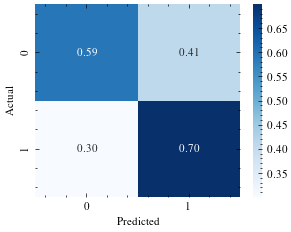

In [140]:
# Train the model on the full training set
ct = ColumnTransformer([('scaler', StandardScaler(), cols_no_dummy)], remainder='passthrough')
ct.set_output(transform='pandas')

X_train_full_scaled = ct.fit_transform(X_train_full)
X_test_scaled = ct.transform(X_test)

X_train_full_lstm, y_train_full_lstm = shape_lstm(X_train_full_scaled, y_train_full, seq_length=5)
X_test_lstm, y_test_lstm = shape_lstm(X_test_scaled, y_test, seq_length=5)

# Set the input_shape for your model based on your input data
input_shape = (5, X_train_full_lstm.shape[2])
model2 = build_lstm_model(input_shape)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()
hist_full = model2.fit(X_train_full_lstm, y_train_full_lstm, epochs=10, batch_size=32)

# Predict on the test set
y_pred = model2.predict(X_test_lstm)

# Evaluate the model
score = model2.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.round(y_pred)
cm = confusion_matrix(y_test_lstm, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [186]:
# dataframe with x = 1,2,3,4
df = pd.DataFrame({'x': [1,2,3,4]})
df.shift(-1)

,x
0,2.0
1,3.0
2,4.0
3,NaN
